<a href="https://colab.research.google.com/github/lonen8188/PythonAI/blob/8-2.Conv2D%2CMaxPooling2D%2Cplot_model/hg_08_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 합성곱 신경망을 사용한 이미지 분류

# 전에 배운 합성곱, 필터, 패딩, 스트라이드, 풀링 등은 직접 계산할 필요가 없다.
# 케라스 API가 알아서 한다. 그러나 개념과 돌아가는 기능에 대한 느낌을 알아야 최적의 결과를 얻을 수 있다.
# 그래서 동작원리를 터득하고 특히 다른 신경망 구조를 만나도 잘 적응할 수 있다.

# 패션 MNIST를 활용하여 응용 해본다.
# 전처리 : 데이터 스케일을 0~255 사이에서 0~1 사이로 바꾸고 훈련 세트와 검증 세트로 나눔
# 차이점은 완전 연결 신경망에서는 입력 이미지를 밀집층에 연결하기 위해 일렬로 펼쳐야 한다.(넘파이 reshape(), Flatten 사용)
#          합성곱 신경망은 2차원 이미지를 그대로 사용하기 때문에 할 필요가 없다.
# 입력이미지는 항상 깊이(채널) 차원이 이 있어야 함
# 흑백 이미지의 경우 채널 차원이 없는 2차원 배열이지만 Conv2D 층을 사용하기 위해 마지막에 이 채널 차원을 추가해야 함
# 넘파이 reshape() 메서드를 이용해 전체 배열 차원을 그대로 유지하면서 마지막에 차원을 간단히 추가함.


import tensorflow as tf
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
tf.keras.utils.set_random_seed(42)

from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data() # 패션 MNIST 데이터 불러오기

train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
# train_input(48000,28,28) -> train_scaled(48000,28,28,1)로 4차원 변경 됨

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)
# 훈련 데이터, 검증 데이터, 훈련타겟, 검증타켓 -> 8:2

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


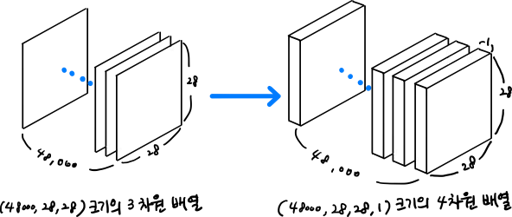

In [2]:
# 합성곱 신경망 만들기 : 합성곱 층으로 미미지에서 특징을 감지한 후 밀집층으로 클래스에 따른 분류 확률을 계산함

model = keras.Sequential() # Sequential 클래스의 객체를 만들듬
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))
#                      Conv2D 층을 add로 추가
#                             32 : 합성곱 층으로 32개의 필터를 사용
#                                 kernel_size=3 : 커널의 크기는 (3,3)
#                                                activation='relu' : 렐루 활성화 함수사용
#                                                                   padding='same' : 세임 패딩 사용
#                                                                                   input_shape=(28,28,1) : 앞에 변경한 이미지를 차원 변경함

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


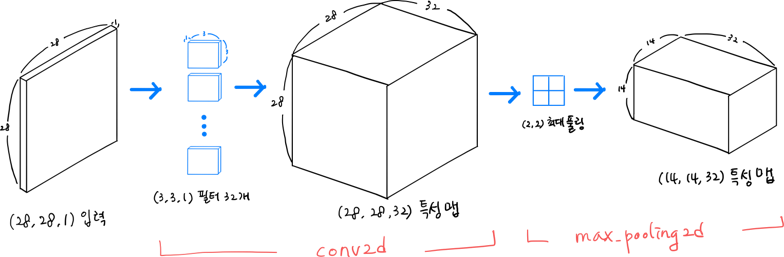

In [3]:
model.add(keras.layers.MaxPooling2D(2))
# 풀링 층 추가 (최대 풀링 (2:2) 특성 맵의 크기는 절반으로 줄어듬
# 합성 곱 층에서 32개의 필터를 사용했기 때문에 특성 맵의 깊이는 32
# 최대풀링을 통과한 특성 맵의 크기는 (14,14,32)

In [4]:
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
# 이번 합성곱 층은 세임 패딩을 사용 (입력의 가로 세로 크기를 줄이지 않음)
model.add(keras.layers.MaxPooling2D(2))
# 이어지는 풀링 층에서 이 크기를 절반으로 줄임, 64개의 필터를 사용했으니 특성맵을 크기는 (7,7,64)

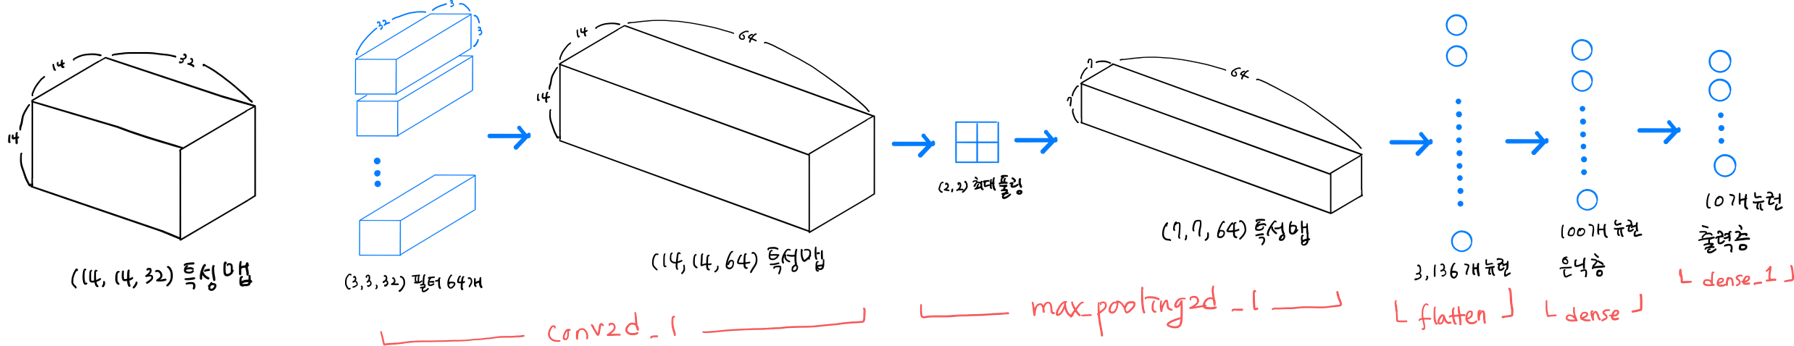

In [5]:
# 3차원 특성 맵을 일렬로 펼칠 차례임 -> 마지막에 10개의 뉴런을 가진 밀집 층에서 확률을 계산
# 이번에는 특성맵을 일렬로 펼쳐서 바로 출력층에 전달하지 않고 중간에 하나의 밀집 은닉층을 하나 추가함
# Flatten -> Dense 은닉층 -> Dropout -> Dense 출력층
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu')) # 은닉층은 100개의 뉴런을 사용하고 활성화 함수는 합성곱과 같은 렐루 사용
model.add(keras.layers.Dropout(0.4)) # 드롭아웃을 이용해 은닉층의 과대적합을 막아 성능을 조금 개선
model.add(keras.layers.Dense(10, activation='softmax')) # 패션 MNIST는 클래스를 10개로 분류하는 다중 분류 문제임으로 활성화 함수는 소프트맥스 사용

In [6]:
model.summary() # 결과 확인
# 합성곱 층과 풀링 층의 효과를 확인 할 수 있다.
# 첫번째 합성곱 층을 통과하면서 특성 맵의 깊이는 32가 됨
# 두번째 합성곱 층을 통과하면서 특성 맵의 크기가 64로 늘어남
# 반면 특성 맵의 가로세로 크기는 첫번째 풀링 층에서 절반으로 줄어들고 두번째 풀링에서 다시 절반으로 줄어듬
# 따라서 최종 특성 맵의 크기는 (7,7,64) 임

# 완전 신경망에서 해던 것 처럼 모델 파라미터 개수는 첫번째 합성곱 층은 32개의 필터를 가지고 있고 크기가 (3,3,) 깊이가 1이고 필터마다 1의 절편이 있음
# 3 * 3 * 1 * 32 + 32 = 320의 파라미터

# 두번째 합성곱 층은 64개의 필터를 사용하게 크기가 (3,3,) 깊이가 32 이고 필터마다 1의 절편이 있음
# 3 * 3 * 3 2 * 64 + 64 = 18496의 파라미터

# Flatten 클래스의 (7,7,64) 크기의 특성 맵을 1차원 배열로 펼치면 (3136,)의 크기의 배열이 됨 이를 100개의 뉴런과 완전히 연결해야 함으로 은닉층의 모델 파라미터 개수
# 3136 * 100 + 100 = 313700의 파라미터

# 마지막 출력층의 모델 파라미터 개수는 1010개

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         313,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,526 (1.27 MB)

 Trainable params: 333,526 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

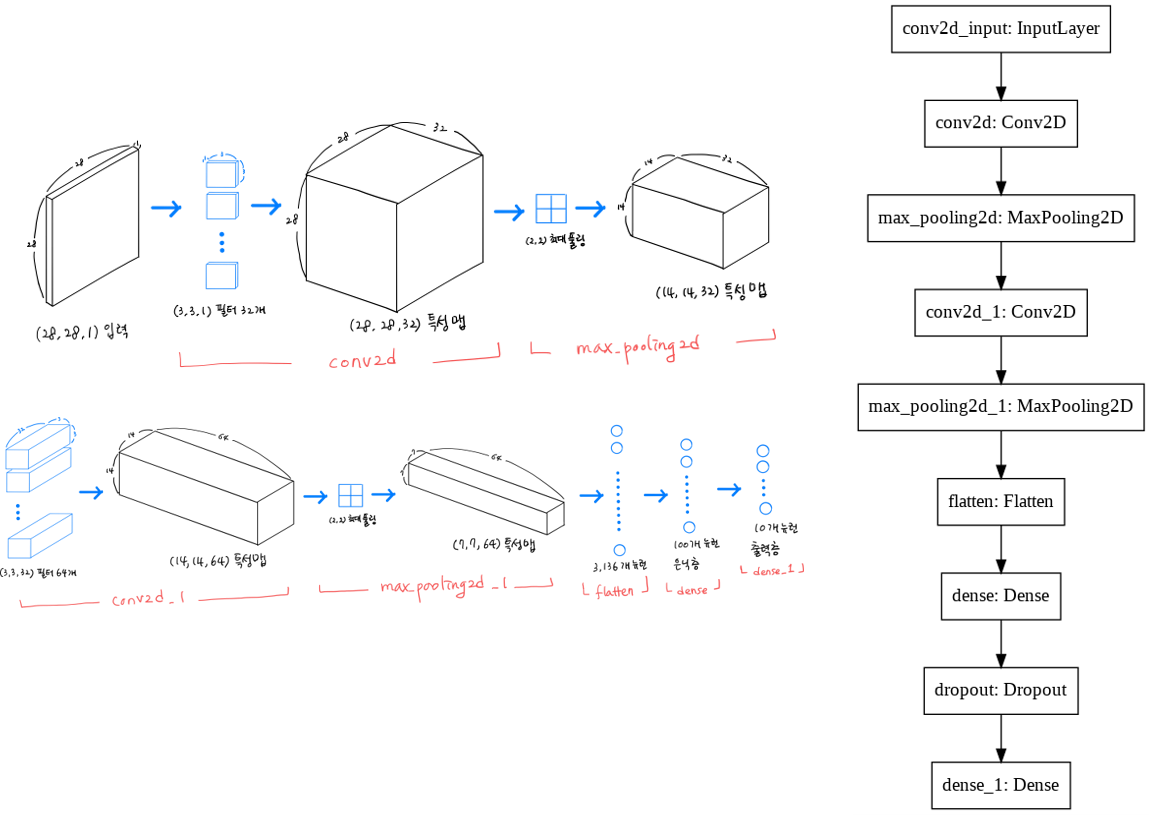

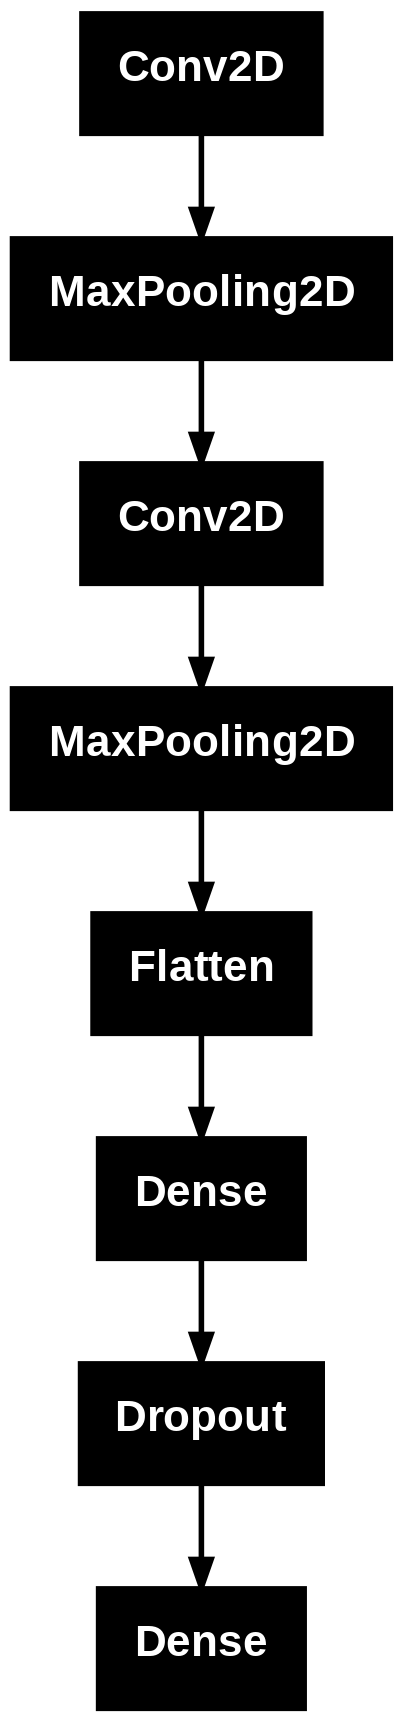

In [7]:
# 케라스는 층의 구성을 그림으로 보여주는 메서드가 있다.  (keras.utils.plot_model)
keras.utils.plot_model(model) # 버전차이

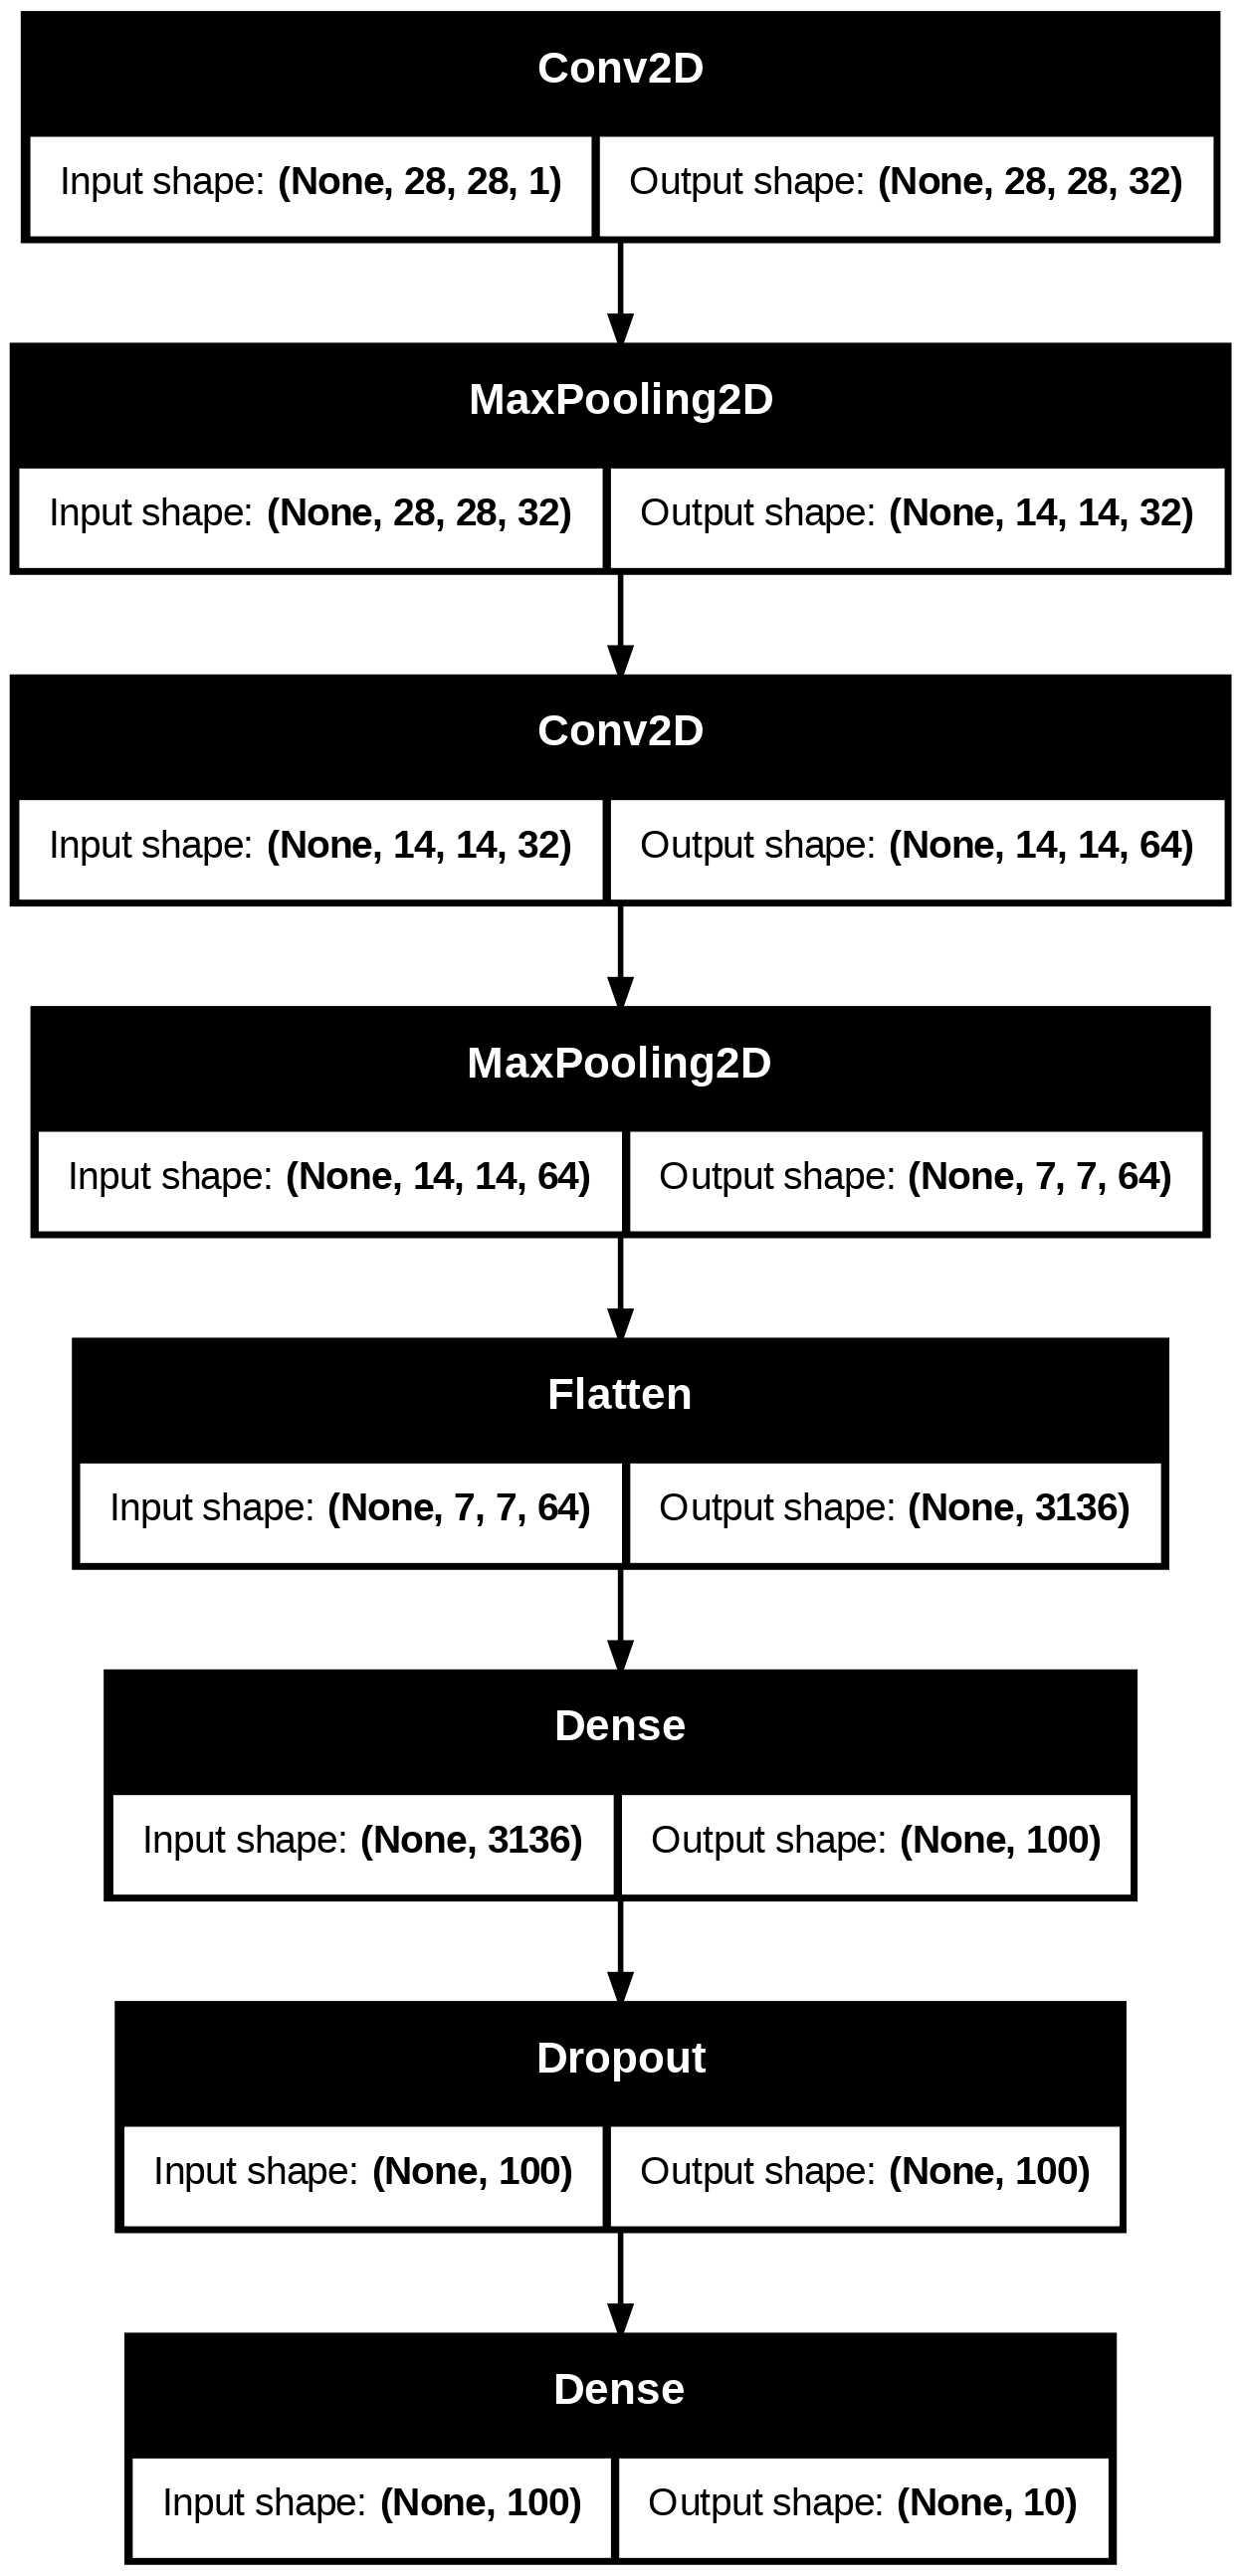

In [8]:
keras.utils.plot_model(model, show_shapes=True) # 입력과 출력 크기를 표시

In [ ]:
# 패션 MNIST 데이터에 적용할 합성곱 신경망 모델의 구성 끝 -> 컴파일하고 훈련 진행 시작!

In [9]:
# 모델 컴파일과 훈련
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# 아담 최적화로 훈련
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.keras',
                                                save_best_only=True)
# ModelCheckpoint 콜백 조기종료
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
# EarlyStopping 콜백 조기 종료
history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7491 - loss: 0.7032 - val_accuracy: 0.8845 - val_loss: 0.3166
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8715 - loss: 0.3548 - val_accuracy: 0.8953 - val_loss: 0.2763
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8911 - loss: 0.3010 - val_accuracy: 0.9107 - val_loss: 0.2434
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9030 - loss: 0.2627 - val_accuracy: 0.9100 - val_loss: 0.2448
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9114 - loss: 0.2431 - val_accuracy: 0.9108 - val_loss: 0.2439


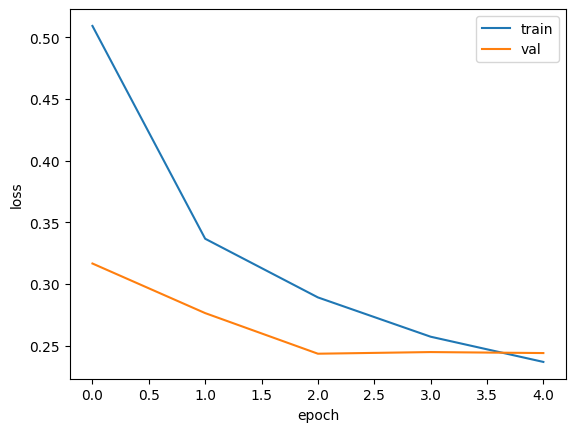

In [10]:
# 훈련 세트 성능이 91퍼 까지 나왔음!
# 손실 그래프를 그려서 조기 종료가 잘 이루어 졌는지 확인해 보자.

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()
# 검증 세트에 대한 손실이 점차 감소하다 정체되기 시작하고 훈련 세트에 대한 손실은 점점 낮아짐
# 이 그래프를 기반으로 다섯번째 에포크를 최적으로 생각할 수 있음 (결과는 학생마다 다를 수 있음)

In [11]:
# EarlyStopping 클래스에서 restore_best_weights=True로 지정해서 현재 model 객체가 최적의 모델 파라미터로 복원됨
# ModelCheckpoint 콜백이 저장한 best-cnn-model.keras 파일을 다시 읽을 필요가 없음

# 이번 세트에 대한 성능 평가 진행
model.evaluate(val_scaled, val_target)
# 이 결과는 fit() 메서드의 출력 중 다섯번째 출력과 비슷함
# EarlyStopping 콜백이 model 객체의 최상의 모델 파라미터로 잘 복원 함

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9150 - loss: 0.2355


[0.24341705441474915, 0.9107499718666077]

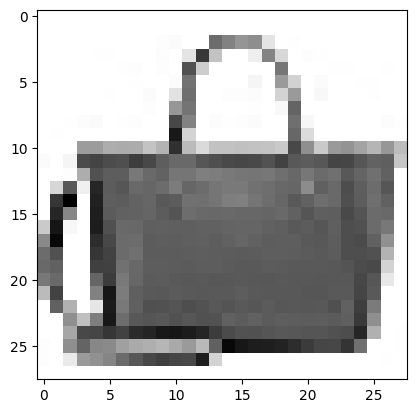

In [13]:
# 편의상 검증 세트의 첫 번째 샘플인 이미지를 활용 해보자.
# 팻플롯립에서 흑백 이미지에 깊이 차원은 없다 -> (28,28,1) 크기를 (28,28)로 변경 reshape(28, 28)
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
# 첫 번째 샘플인 val_scaled[0]
plt.show()

In [14]:
# 확율 예측 시도 predict() 메서드는 10개의 클래스에 대한 예측 확률을 출력
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
[[2.87678166e-13 1.01866518e-16 4.29244415e-14 1.20574046e-11
  3.47132045e-12 5.27468287e-14 3.73623387e-13 1.16464728e-11
  1.00000000e+00 1.10791408e-13]]


In [ ]:
# 결과를 보면 9번째 값이 1로 판단되고 나머지는 지수형식으로 나왔는데 e-가 있으면 마이너스 임(0에 가까움)
# 5e3 -> 5x10^3
# 5e-3 -> 5x10^-3

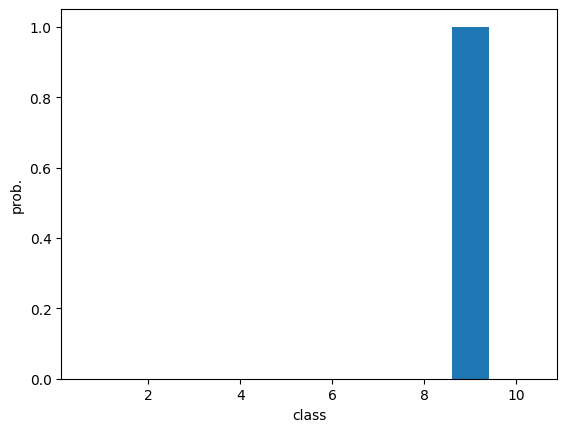

In [15]:
# 막대그래프로 표시
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [16]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']
# 레이블 추가

In [20]:
import numpy as np
print(classes[np.argmax(preds)]) # 가방 예측 성공

가방


In [21]:
# 맨 처음 떼어 놓았던 테스트 세트로 합성곱 신경망의 일반화 성능을 파악해보자.
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0
# 훈련세트와 검증 세트에서 했던 것 처럼 픽셀 값의 범위를 0~1 사이로 바꾸고 이미지 크기를 (28,28,1)로 변경

In [22]:
model.evaluate(test_scaled, test_target)
# 테스트 세트에서 점수는 검증 세트보다 조금 작음
# 이 모델을 실전에 투입하면 90% 이상의 성능을 기대할 수 있음

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9015 - loss: 0.2762


[0.2683645486831665, 0.9010999798774719]